## Gaussian Process Persistent Homology

This notebook deals with persistent homology based on the Wasserstein distance between Gaussian Processes fit to time series.

In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import scipy.linalg as sl
import GPy
import dionysus as d
import matplotlib.pyplot as plt
from itertools import combinations
import pymysql
from sqlalchemy import create_engine
import tqdm
import sys

engine = create_engine('mysql+pymysql://alcuin:@localhost:3306/ztf', echo = False)

### Distance between two time series

Consider two time series $\{t_i, y_i\}$, for $i = 1, \ldots, n_1$, and $\{t'_j, y'_j\}$, for $j = 1, \ldots, n_2$, and a prior GP $f \sim \cal{GP}(m, k)$ with mean function $m$ and kernel function $k$. We define a set of uniformly sampled times $\{t^*_k\}$ for $k = 1, \ldots, m$ over the time range for which $f$ is defined and then compute the posterior distributions over this: $Y_1 \sim (f | t_i, y_i, t^*_k)$ and $Y_2 \sim (f | t'_j, y'_j, t^*_k)$. The squared 2-Wasserstein distance between the two GPs is given by (Mallasto & Feragen 2017):

$ W^2_2(Y_1, Y_2) = d_2^2(m_1, m_2) + Tr\left(K_1 + K_2 - 2(K_1^{1/2} K_2 K_1^{1/2})^{1/2}\right)$

In [2]:
def GPFit(t, y, yerr, kern = 'OU'):
  # Fit GP model
  kern = GPy.kern.OU(1) + GPy.kern.White(1)
  yp = y - y.mean()
  m = GPy.models.GPHeteroscedasticRegression(t[:, None], yp[:, None], kern)
  m['.*het_Gauss.variance'] = abs(yerr ** 2.)[:, None] # Set the noise parameters to the error in Y
  m.het_Gauss.variance.fix() # We can fix the noise term, since we already know it
  m.optimize()
  return m


def wass2(k1, k2):
  # Squared Wasserstein-2 distance between two Gaussian processes with zero means
  # Note that this is symmetrical: W2^2(k1, k2) = W2^2(k2, k1)
  assert k1.shape == k2.shape, "k1 and k2 must have the same dimensionality"
  k1sqrt = sl.sqrtm(k1)  
  kp = k1sqrt @ (k2 @ k1sqrt)
  k = k1 + k2 - 2. * sl.sqrtm(kp)
  return np.trace(k)


def dist(data1, data2, tk):
  # Fit a GP to two time series and determine the distance therefrom
  gp1 = GPFit(data1[0], data1[1], data1[2])
  gp2 = GPFit(data2[0], data2[1], data2[2])
  mu1, covar1 = gp1._raw_predict(tk[:, None], full_cov = True)
  mu2, covar2 = gp2._raw_predict(tk[:, None], full_cov = True)
  return wass2(covar1, covar2)

### Distance matrix for a set of time series

For a set of time series, it is inefficient to recalculate the GP for individual time series to determine elements in the distance matrix for the set. However, $W_2$ is only dependent on the posterior covariance matrix of the uniform time sampling $t^*_k$.

In [8]:
DATA_DIR = {'crts': '/Users/mjg/Projects/data/crts/'}

def getData(id, survey = 'crts'):
  field = str(id)[:7]
  raw = pd.read_csv(f'{DATA_DIR[survey]}/{field}/{str(id)}.dat', delim_whitespace = True, 
                  header = None, names = ['mjd', 'mag', 'magerr'])
  data = raw.to_numpy().T
  return data


def get_tk(ts_set, survey = 'crts', len_tk = 1000):
  tmin, tmax = 100000., 0.
  for i, x in ts_set.iterrows():
    field = str(x['id'])[:7]
    raw = pd.read_csv(f"{DATA_DIR[survey]}/{field}/{str(x['id'])}.dat", delim_whitespace = True, 
                     header = None, names = ['mjd', 'mag', 'magerr'])
    tmin = min(tmin, raw['mjd'].min())
    tmax = max(tmax, raw['mjd'].max())
  tk = np.linspace(tmin, tmax, len_tk)
  return tk

In [9]:
query = 'select id from qso.flare17'
res = pd.read_sql_query(query, engine)
covar = {} 
tk = get_tk(res, len_tk = 100)
for i, x in tqdm.tqdm(res.iterrows()):
  data = getData(x['id'])
  gp = GPFit(data[0], data[1], data[2])
  covar[x['id']] = gp._raw_predict(tk[:, None], full_cov = True)

51it [00:22,  2.24it/s]


In [10]:
dist = np.zeros([len(covar), len(covar)])
keys = list(covar.keys())
for i in range(len(covar)):
  for j in tqdm.tqdm(range(i + 1, len(covar))):
    dist[i, j] = wass2(covar[keys[i]][1], covar[keys[j]][1])
    dist[j, i] = dist[i, j]

100%|██████████| 1/1 [00:00<00:00, 16.54it/s]
0it [00:00, ?it/s]


In [7]:
fulldist = dist

### Persistent homology

Once we have the distance matrix, we can compute a Vietoris-Rips complex for the point data cloud defined by the time series set.

In [105]:
from scipy.spatial.distance import squareform
pdist = squareform(dist) # convert square-form distance matrix to condensed form
f = d.fill_rips(pdist, 3, 0.3)

In [106]:
m = d.homology_persistence(f)
dgms = d.init_diagrams(m, f)

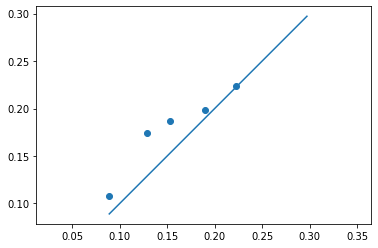

In [113]:
d.plot.plot_diagram(dgms[1], show = True)

In [108]:
dgms

[Diagram with 51 points,
 Diagram with 6 points,
 Diagram with 0 points,
 Diagram with 21 points]